#Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import libraries

In [ ]:
seed=42
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

#Universal variables

In [ ]:
numero_cicli=2
fs=128
bpm_min=40
lunghezza_max=int(60*numero_cicli*fs/bpm_min)
input_shape = [lunghezza_max,1]
batch_size = 256
epochs = 50
LR = 0.0005
patience_ES = 10
patience_LR = 5
factor_LR = 0.5

#Load data

In [ ]:
train_central_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_centra_peaks_N.npy')
train_central_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_centra_peaks_S.npy')
train_central_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_centra_peaks_V.npy')
train_single_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_single_peaks_V.npy',allow_pickle=True)
train_single_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_single_peaks_N.npy',allow_pickle=True)
train_single_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/training_single_peaks_S.npy',allow_pickle=True)


val_central_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_centra_peaks_N.npy')
val_central_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_centra_peaks_S.npy')
val_central_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_centra_peaks_V.npy')
val_single_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_V.npy',allow_pickle=True)
val_single_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_N.npy',allow_pickle=True)
val_single_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_S.npy',allow_pickle=True)


test_central_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_centra_peaks_N.npy')
test_central_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_centra_peaks_S.npy')
test_central_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_centra_peaks_V.npy')
test_single_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_V.npy',allow_pickle=True)
test_single_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_N.npy',allow_pickle=True)
test_single_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_S.npy',allow_pickle=True)

#Zero-padding on signals


In [ ]:
#function that zero pads single_peaks_X in order to obtain the same length for all the signals
#we thought that streatch the signals would modify them too much
def zero_pad_signals(single_peaks_X,lunghezza_max=384):
  single_peaks_X_new=[]
  for i in range(single_peaks_X.shape[0]):
    difference=lunghezza_max-single_peaks_X[i].shape[0]
    if difference%2==0:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2))],axis=0)
    else:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2+1))],axis=0)
    single_peaks_X_new.append(new_signal)
  return np.array(single_peaks_X_new)

In [ ]:
train_single_peaks_V=zero_pad_signals(train_single_peaks_V)
train_single_peaks_N=zero_pad_signals(train_single_peaks_N)
train_single_peaks_S=zero_pad_signals(train_single_peaks_S)

val_single_peaks_V=zero_pad_signals(val_single_peaks_V)
val_single_peaks_N=zero_pad_signals(val_single_peaks_N)
val_single_peaks_S=zero_pad_signals(val_single_peaks_S)

test_single_peaks_V=zero_pad_signals(test_single_peaks_V)
test_single_peaks_N=zero_pad_signals(test_single_peaks_N)
test_single_peaks_S=zero_pad_signals(test_single_peaks_S)


#Train-Validation-Test

In [ ]:
print(test_single_peaks_N.shape[0])
print(test_single_peaks_S.shape[0]+test_single_peaks_V.shape[0])

18934
3678


In [ ]:
numero_minimo=train_single_peaks_V.shape[0]+train_single_peaks_S.shape[0]+val_single_peaks_V.shape[0]+val_single_peaks_S.shape[0]
print(numero_minimo)
print(train_single_peaks_N.shape[0])
print(val_single_peaks_N.shape[0])

7550
81381
38511


In [ ]:
81381+38511

119892

In [ ]:
3*7550

22650

In [ ]:
119892%(3*7550)

6642

In [ ]:
train_N=np.concatenate([train_single_peaks_N,val_single_peaks_N],axis=0)
train_SV=np.concatenate([train_single_peaks_S,val_single_peaks_S,train_single_peaks_V,val_single_peaks_V],axis=0)

val_N=test_single_peaks_N
val_SV=np.concatenate([test_single_peaks_S,test_single_peaks_V],axis=0)

#[0] -> N
#[1] -> SV
lunghezza_SV=train_SV.shape[0]
lunghezza=3*lunghezza_SV
lunghezza_val_SV=val_SV.shape[0]
lunghezza_val=lunghezza_val_SV

X_train1=np.concatenate([train_N[:lunghezza],train_SV],axis=0)
y_train1=np.concatenate([np.zeros(lunghezza),np.ones(lunghezza_SV)],axis=0)
X_val1=np.concatenate([val_N[:lunghezza_val],val_SV],axis=0)
y_val1=np.concatenate([np.zeros(lunghezza_val),np.ones(lunghezza_val_SV)],axis=0)

X_train2=np.concatenate([train_N[lunghezza:2*lunghezza],train_SV],axis=0)
y_train2=np.concatenate([np.zeros(lunghezza),np.ones(lunghezza_SV)],axis=0)
X_val2=np.concatenate([val_N[lunghezza_val:2*lunghezza_val],val_SV],axis=0)
y_val2=np.concatenate([np.zeros(lunghezza_val),np.ones(lunghezza_val_SV)],axis=0)

X_train3=np.concatenate([train_N[2*lunghezza:3*lunghezza],train_SV],axis=0)
y_train3=np.concatenate([np.zeros(lunghezza),np.ones(lunghezza_SV)],axis=0)
X_val3=np.concatenate([val_N[2*lunghezza_val:3*lunghezza_val],val_SV],axis=0)
y_val3=np.concatenate([np.zeros(lunghezza_val),np.ones(lunghezza_val_SV)],axis=0)

X_train4=np.concatenate([train_N[3*lunghezza:4*lunghezza],train_SV],axis=0)
y_train4=np.concatenate([np.zeros(lunghezza),np.ones(lunghezza_SV)],axis=0)
X_val4=np.concatenate([val_N[3*lunghezza_val:4*lunghezza_val],val_SV],axis=0)
y_val4=np.concatenate([np.zeros(lunghezza_val),np.ones(lunghezza_val_SV)],axis=0)

X_train5=np.concatenate([train_N[4*lunghezza:],train_SV],axis=0)
y_train5=np.concatenate([np.zeros(train_N[4*lunghezza:].shape[0]),np.ones(lunghezza_SV)],axis=0)
X_val5=np.concatenate([val_N[4*lunghezza_val:],val_SV],axis=0)
y_val5=np.concatenate([np.zeros(val_N[4*lunghezza_val:].shape[0]),np.ones(lunghezza_val_SV)],axis=0)


np.random.shuffle([X_train1,y_train1])
np.random.shuffle([X_train2,y_train2])
np.random.shuffle([X_train3,y_train3])
np.random.shuffle([X_train4,y_train4])
np.random.shuffle([X_train5,y_train5])

#Modello

In [ ]:
def build_model(input_shape1, LR):

  # time model
  input_layer1 = tfkl.Input(shape=input_shape1, name='input_layer1')
  x1 = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer1)
  x1 = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x1)
  x1=tfkl.MaxPool1D(2)(x1)
  x1 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x1)
  x1 = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x1)
  x1=tfkl.MaxPool1D(2)(x1)
  x1 = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x1)
  x1=tfkl.MaxPool1D(2)(x1)
  x1 = tfkl.Conv1D(32, 3, padding='same', activation='relu')(x1)
  x1=tfkl.MaxPool1D(2)(x1)

  x1=tfkl.GlobalAveragePooling1D()(x1)

  output_layer = tfkl.Dense(1, activation='sigmoid')(x1)

  model = tf.keras.Model(inputs=[input_layer1], outputs=output_layer, name='CONV_LSTM_model')
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(LR), metrics = ['accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')]
  )

  return model

In [ ]:
CLASS_WEIGHT = {
    0:1/3,
    1:1,
}
print(CLASS_WEIGHT)

{0: 0.3333333333333333, 1: 1}


Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer1 (InputLayer)   [(None, 384, 1)]          0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 384, 128)          33792     
 ectional)                                                       
                                                                 
 conv1 (Conv1D)              (None, 384, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 192, 128)          0         
 D)                                                              
                                                                 
 bidirectional_lstm2 (Bidir  (None, 192, 256)          263168    
 ectional)                                                       
                                                   

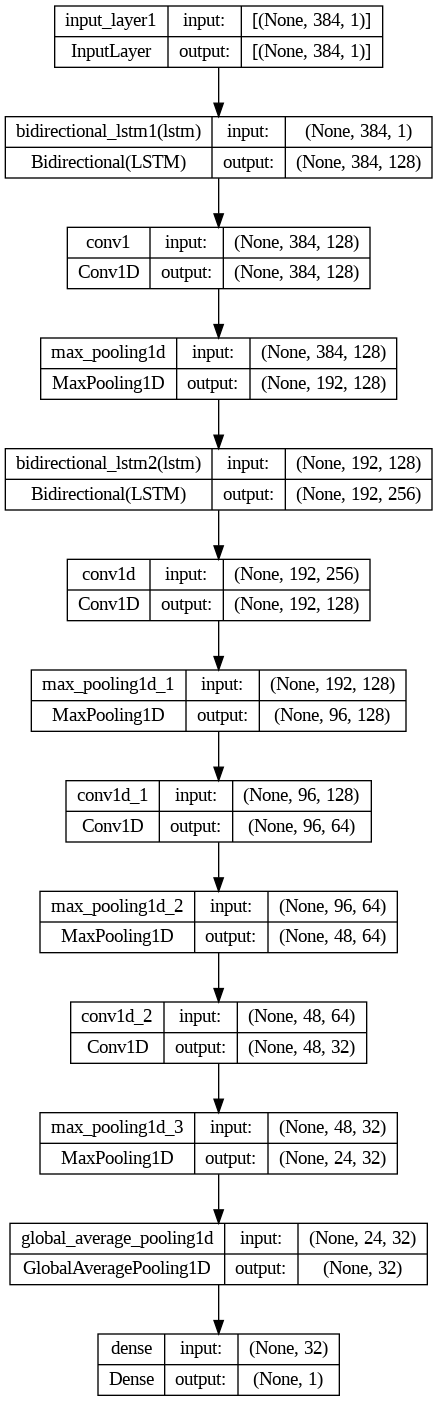

In [ ]:
model = build_model(input_shape, LR)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x =[X_train2],
    y = y_train2,
    batch_size = batch_size,
    epochs = epochs,
    class_weight=CLASS_WEIGHT,
    validation_data=([X_val2],y_val2),
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='recall_S', mode='max', patience=50),
        #tfk.callbacks.EarlyStopping(monitor='recall_V', mode='max', patience=50),
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15),
        tfk.callbacks.ReduceLROnPlateau(monitor='recall', mode='max', patience=patience_LR, factor=factor_LR, min_lr=1e-5)
    ]
).history

Epoch 1/50
118/118 [==============================] - 31s 148ms/step - loss: 0.1638 - accuracy: 0.8653 - recall: 0.8964 - precision: 0.6732 - val_loss: 0.3956 - val_accuracy: 0.8549 - val_recall: 0.9244 - val_precision: 0.8116 - lr: 5.0000e-04
Epoch 2/50
118/118 [==============================] - 14s 117ms/step - loss: 0.0939 - accuracy: 0.9341 - recall: 0.9311 - precision: 0.8271 - val_loss: 0.3074 - val_accuracy: 0.8802 - val_recall: 0.8910 - val_precision: 0.8722 - lr: 5.0000e-04
Epoch 3/50
118/118 [==============================] - 14s 117ms/step - loss: 0.0739 - accuracy: 0.9510 - recall: 0.9442 - precision: 0.8706 - val_loss: 0.3226 - val_accuracy: 0.8980 - val_recall: 0.9505 - val_precision: 0.8602 - lr: 5.0000e-04
Epoch 4/50
118/118 [==============================] - 14s 118ms/step - loss: 0.0721 - accuracy: 0.9509 - recall: 0.9458 - precision: 0.8693 - val_loss: 0.3108 - val_accuracy: 0.8877 - val_recall: 0.9668 - val_precision: 0.8347 - lr: 5.0000e-04
Epoch 5/50
118/118 [====

In [ ]:
model.save('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSABLE_2')

#predict

In [ ]:
y=model.predict(X_val2)

230/230 [==============================] - 5s 17ms/step


In [ ]:
y_post=[]
for i in range(y.shape[0]):
  if y[i]<0.5:
    y_post.append(0)
  else:
    y_post.append(1)
y=np.array(y_post)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val2, y)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3083  595]
 [ 100 3578]]


              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      3678
         1.0       0.86      0.97      0.91      3678

    accuracy                           0.91      7356
   macro avg       0.91      0.91      0.91      7356
weighted avg       0.91      0.91      0.91      7356



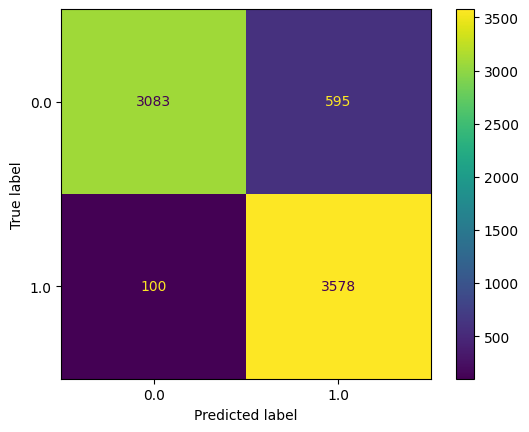

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(y_val2, y)

print(classification_report(y_val2,y))

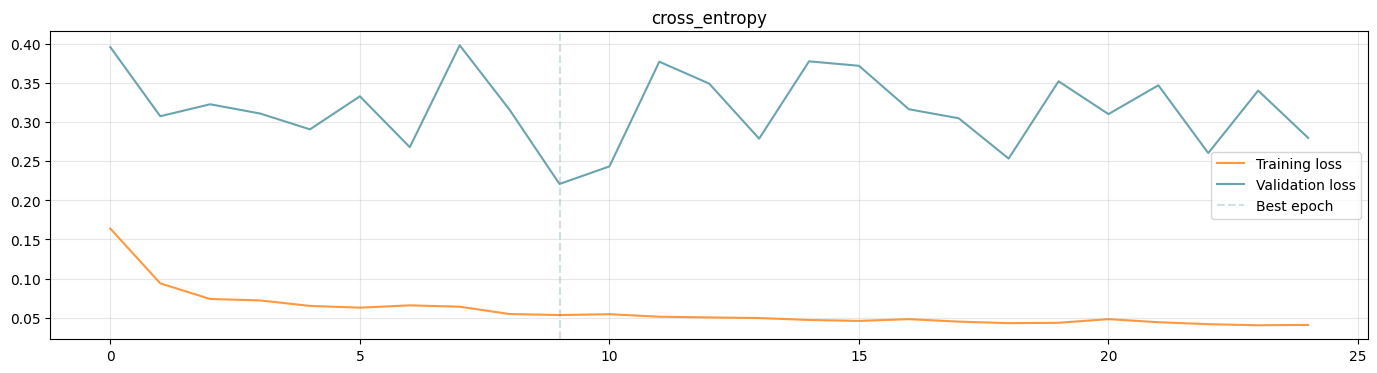

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('cross_entropy')
plt.legend()
plt.grid(alpha=.3)
#plt.savefig(training_path +'/loss.png')
plt.show()